# Neural Ordinary Differential Equations

**Learning Objectives:**
- Understand the connection between ResNets and continuous dynamics
- Master the adjoint method for memory-efficient backpropagation
- Apply Neural ODEs to learn dynamical systems

**Notebook:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/07-neural-ode/neural-ode.ipynb)

**Paper:** [![Neural ODE Paper](https://img.shields.io/badge/View-Paper-red?style=flat-square&logo=adobeacrobatreader&logoColor=white)](https://arxiv.org/abs/1806.07366)

---

**Reference:** Chen et al., "Neural Ordinary Differential Equations," NeurIPS 2018 (Best Paper)

## From ResNets to Continuous Dynamics

### The ResNet Formula

A residual network transforms the hidden state at each layer:

$$h_{t+1} = h_t + f(h_t, \theta_t)$$

where $t \in \{0, 1, \ldots, T\}$ indexes discrete layers.

### The Key Insight

This is **Euler's method** for solving an ODE. As we add more layers and take smaller steps:

$$\frac{dh(t)}{dt} = f(h(t), t, \theta)$$

Instead of discrete layers, we parameterize the **derivative** of the hidden state.

### Three Key Advantages

1. **Memory Efficiency**: $\mathcal{O}(1)$ vs $\mathcal{O}(L)$ via adjoint method
2. **Adaptive Computation**: ODE solvers adjust evaluations automatically  
3. **Continuous Time**: Natural for irregular data and physical systems

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

# Add torchdiffeq to path
sys.path.insert(0, './torchdiffeq')
from torchdiffeq import odeint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## The Adjoint Method

### The Memory Problem

Standard backpropagation through an ODE solver:
- Must store all intermediate states
- Memory: $\mathcal{O}(\text{NFE})$ where NFE = number of function evaluations

### The Solution

Define the **adjoint state** $a(t) = \frac{\partial L}{\partial h(t)}$, which evolves backward:

$$\frac{da(t)}{dt} = -a(t)^T \frac{\partial f(h(t), t, \theta)}{\partial h}$$

Gradients for parameters:

$$\frac{dL}{d\theta} = -\int_{t_1}^{t_0} a(t)^T \frac{\partial f(h(t), t, \theta)}{\partial \theta} dt$$

**Key property**: Memory cost is $\mathcal{O}(1)$ - independent of number of evaluations!

## Example: Learning Spiral Dynamics

This is the main example from the Neural ODE paper (Section 5.1), implemented in `torchdiffeq/examples/ode_demo.py`.

**True dynamics:**
$$\frac{dz}{dt} = A z^3$$

where $A = \begin{bmatrix} -0.1 & 2.0 \\ -2.0 & -0.1 \end{bmatrix}$

The network learns to approximate these dynamics from data.

In [2]:
# Generate true spiral data (from ode_demo.py)
data_size = 1000
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

print(f"Data shape: {true_y.shape}")

Data shape: torch.Size([1000, 1, 2])


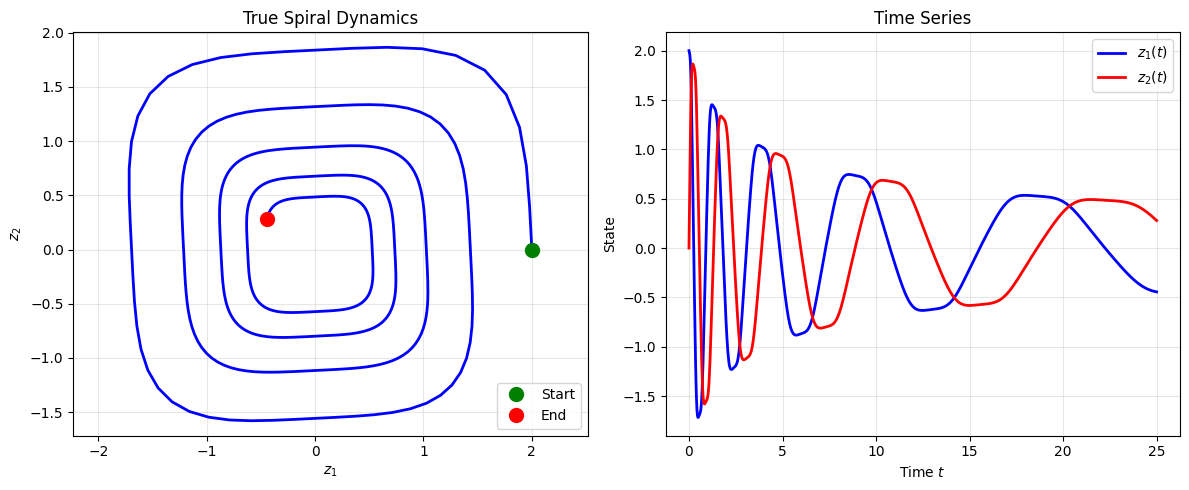

In [3]:
# Visualize true spiral
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

t_np = t.cpu().numpy()
y_np = true_y.cpu().numpy()

ax1.plot(y_np[:, 0, 0], y_np[:, 0, 1], 'b-', linewidth=2)
ax1.plot(y_np[0, 0, 0], y_np[0, 0, 1], 'go', markersize=10, label='Start')
ax1.plot(y_np[-1, 0, 0], y_np[-1, 0, 1], 'ro', markersize=10, label='End')
ax1.set_xlabel('$z_1$')
ax1.set_ylabel('$z_2$')
ax1.set_title('True Spiral Dynamics')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

ax2.plot(t_np, y_np[:, 0, 0], 'b-', label='$z_1(t)$', linewidth=2)
ax2.plot(t_np, y_np[:, 0, 1], 'r-', label='$z_2(t)$', linewidth=2)
ax2.set_xlabel('Time $t$')
ax2.set_ylabel('State')
ax2.set_title('Time Series')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/spiral_data.png', dpi=150, bbox_inches='tight')
plt.show()

### Train Neural ODE (exact implementation from torchdiffeq)

In [4]:
# Exact ODEFunc from ode_demo.py
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    
    def forward(self, t, y):
        return self.net(y**3)

# Exact batch function from ode_demo.py
batch_time = 10
batch_size = 20

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), 
                                          batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Train exactly as in ode_demo.py
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

niters = 2000
test_freq = 100
losses = []

print("Training Neural ODE...")
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            test_loss = torch.mean(torch.abs(pred_y - true_y))
            print(f'Iter {itr:04d} | Loss {test_loss:.6f}')

print("Training complete!")

Training Neural ODE...
Iter 0100 | Loss 0.416710
Iter 0200 | Loss 0.523408
Iter 0300 | Loss 0.352508
Iter 0400 | Loss 0.436913
Iter 0500 | Loss 0.264620
Iter 0600 | Loss 0.237304
Iter 0700 | Loss 0.269090
Iter 0800 | Loss 0.155739
Iter 0900 | Loss 0.413036
Iter 1000 | Loss 0.124993
Iter 1100 | Loss 0.281592
Iter 1200 | Loss 0.292629
Iter 1300 | Loss 0.407221
Iter 1400 | Loss 0.136192
Iter 1500 | Loss 0.169963
Iter 1600 | Loss 0.612340
Iter 1700 | Loss 0.158905
Iter 1800 | Loss 0.735187
Iter 1900 | Loss 0.100252
Iter 2000 | Loss 0.310217
Training complete!


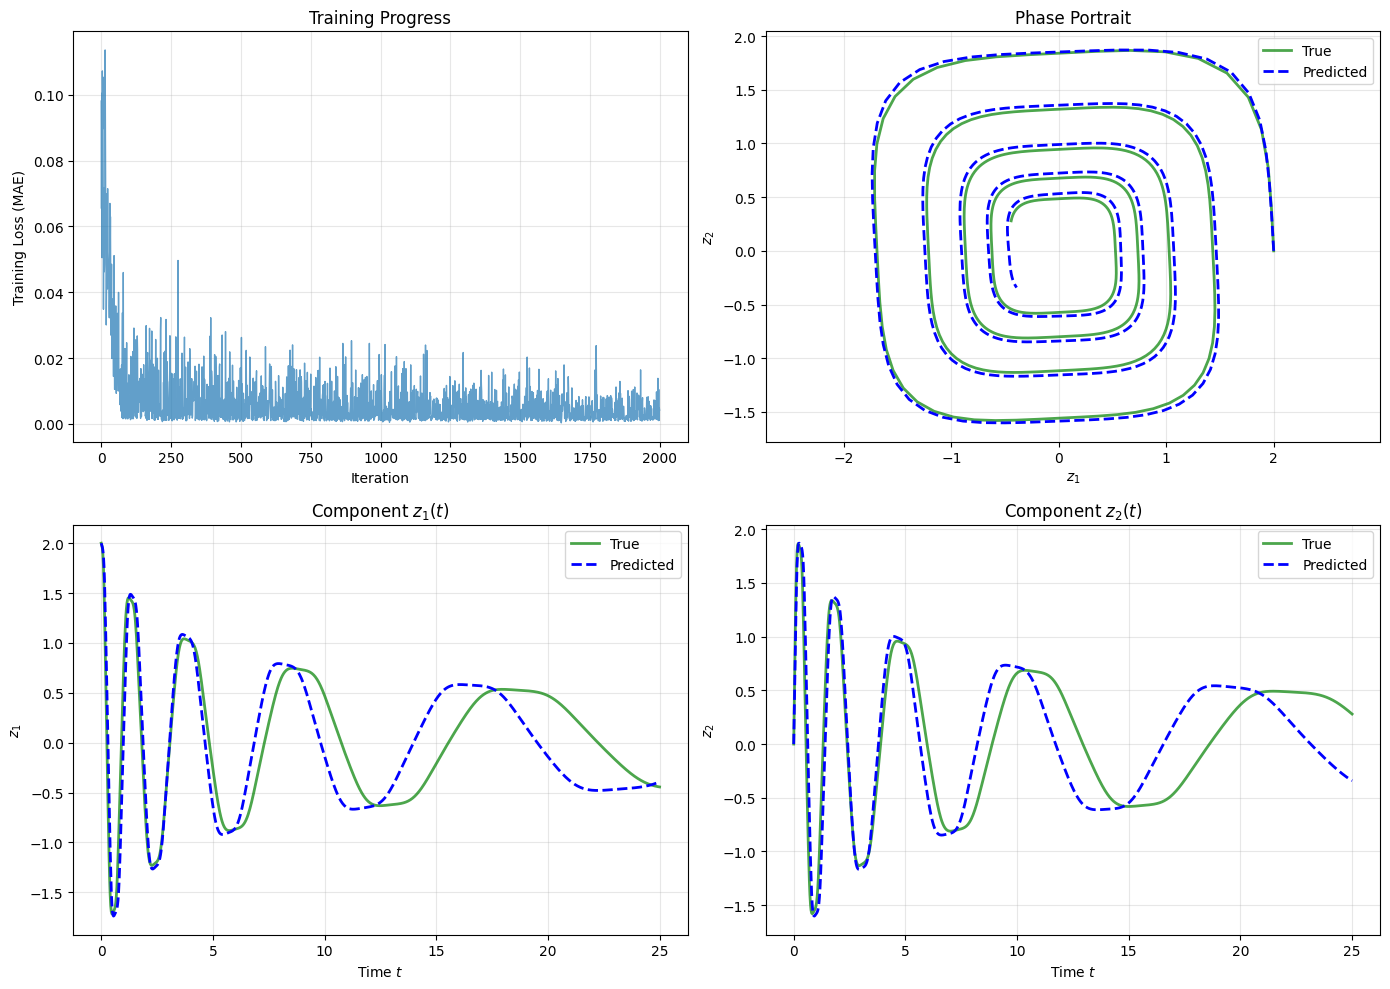

Final MAE: 0.310217


In [5]:
# Evaluate final model
with torch.no_grad():
    pred_y = odeint(func, true_y0, t)

pred_y_np = pred_y.cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curve
axes[0, 0].plot(losses, linewidth=1, alpha=0.7)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Training Loss (MAE)')
axes[0, 0].set_title('Training Progress')
axes[0, 0].grid(True, alpha=0.3)

# Phase portrait
axes[0, 1].plot(y_np[:, 0, 0], y_np[:, 0, 1], 'g-', linewidth=2, alpha=0.7, label='True')
axes[0, 1].plot(pred_y_np[:, 0, 0], pred_y_np[:, 0, 1], 'b--', linewidth=2, label='Predicted')
axes[0, 1].set_xlabel('$z_1$')
axes[0, 1].set_ylabel('$z_2$')
axes[0, 1].set_title('Phase Portrait')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axis('equal')

# Time series z1
axes[1, 0].plot(t_np, y_np[:, 0, 0], 'g-', linewidth=2, alpha=0.7, label='True')
axes[1, 0].plot(t_np, pred_y_np[:, 0, 0], 'b--', linewidth=2, label='Predicted')
axes[1, 0].set_xlabel('Time $t$')
axes[1, 0].set_ylabel('$z_1$')
axes[1, 0].set_title('Component $z_1(t)$')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series z2
axes[1, 1].plot(t_np, y_np[:, 0, 1], 'g-', linewidth=2, alpha=0.7, label='True')
axes[1, 1].plot(t_np, pred_y_np[:, 0, 1], 'b--', linewidth=2, label='Predicted')
axes[1, 1].set_xlabel('Time $t$')
axes[1, 1].set_ylabel('$z_2$')
axes[1, 1].set_title('Component $z_2(t)$')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/spiral_results.png', dpi=150, bbox_inches='tight')
plt.show()

final_error = torch.mean(torch.abs(pred_y - true_y))
print(f"Final MAE: {final_error.item():.6f}")

/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_24401/1407299448.py:31: RuntimeWarning: invalid value encountered in divide
  true_dydt_norm = (true_dydt / true_mag).reshape(21, 21, 2)


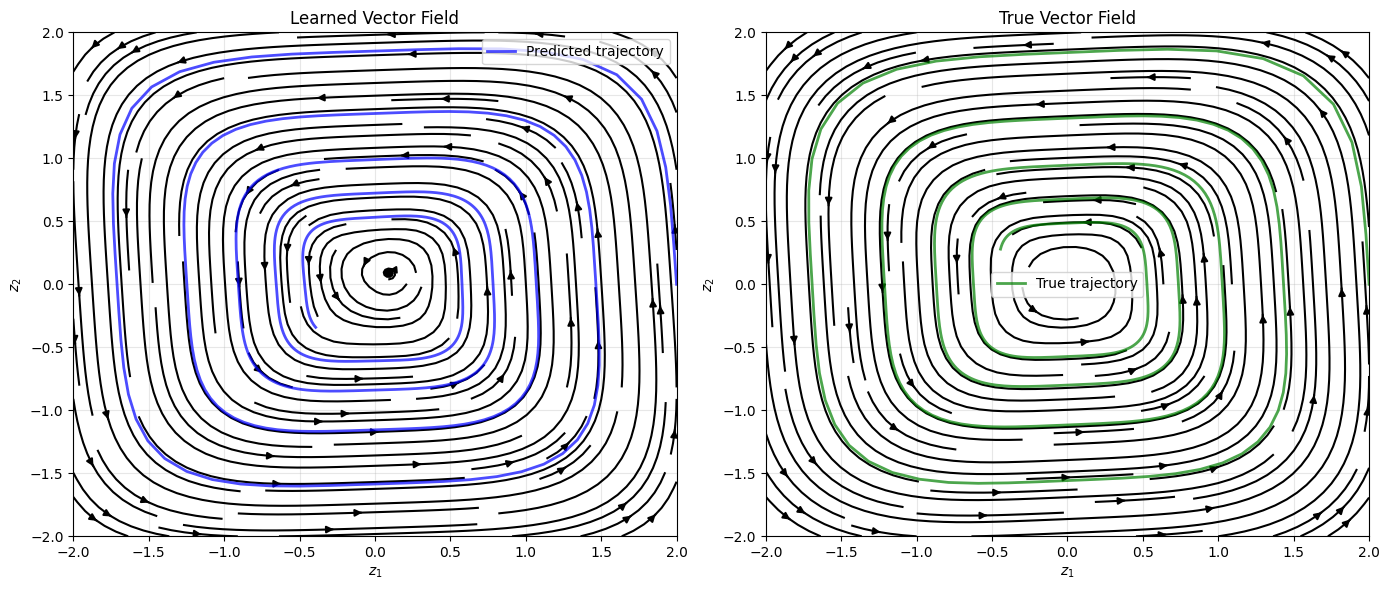

In [6]:
# Visualize learned vector field
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create grid
y_grid, x_grid = np.mgrid[-2:2:21j, -2:2:21j]
grid_points = torch.Tensor(np.stack([x_grid, y_grid], -1).reshape(21 * 21, 2)).to(device)

# Compute learned dynamics
with torch.no_grad():
    dydt = func(0, grid_points).cpu().numpy()

mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
dydt_norm = (dydt / mag).reshape(21, 21, 2)

# Learned field
ax1.streamplot(x_grid, y_grid, dydt_norm[:, :, 0], dydt_norm[:, :, 1], color='black', density=1.5)
ax1.plot(pred_y_np[:, 0, 0], pred_y_np[:, 0, 1], 'b-', linewidth=2, alpha=0.7, label='Predicted trajectory')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_xlabel('$z_1$')
ax1.set_ylabel('$z_2$')
ax1.set_title('Learned Vector Field')
ax1.legend()
ax1.grid(True, alpha=0.3)

# True field
with torch.no_grad():
    true_dydt = Lambda()(0, grid_points).cpu().numpy()

true_mag = np.sqrt(true_dydt[:, 0]**2 + true_dydt[:, 1]**2).reshape(-1, 1)
true_dydt_norm = (true_dydt / true_mag).reshape(21, 21, 2)

ax2.streamplot(x_grid, y_grid, true_dydt_norm[:, :, 0], true_dydt_norm[:, :, 1], color='black', density=1.5)
ax2.plot(y_np[:, 0, 0], y_np[:, 0, 1], 'g-', linewidth=2, alpha=0.7, label='True trajectory')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_xlabel('$z_1$')
ax2.set_ylabel('$z_2$')
ax2.set_title('True Vector Field')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/vector_fields.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

### What We Learned

1. **Conceptual Foundation**
   - ResNets are Euler discretizations: $h_{t+1} = h_t + f(h_t) \to \frac{dh}{dt} = f(h, t)$
   - Neural ODEs parameterize continuous dynamics

2. **Key Advantages**
   - **Memory**: $\mathcal{O}(1)$ via adjoint method
   - **Adaptive**: ODE solvers adjust computation automatically
   - **Continuous**: Natural for physical systems and irregular data

3. **Spiral Example**
   - Learned complex nonlinear dynamics: $\frac{dz}{dt} = A z^3$
   - Network approximates the true vector field
   - Training uses mini-batches of trajectory segments

### When to Use Neural ODEs

**Good for:**
- Modeling physical systems with continuous dynamics
- Very deep networks (memory constrained)
- Irregular time series
- Learning dynamical systems from data

**Challenges:**
- Training can be slower than ResNets
- Requires tuning ODE solver tolerances
- Numerical stability considerations

### Extensions

- **Augmented Neural ODEs**: Add extra dimensions for capacity
- **Hamiltonian Neural Networks**: Preserve physical structure
- **Latent ODEs**: For irregular time series
- **Continuous Normalizing Flows**: Generative modeling

### References

1. Chen et al., "Neural Ordinary Differential Equations," NeurIPS 2018
2. Grathwohl et al., "FFJORD: Free-form Continuous Dynamics for Scalable Reversible Generative Models," ICLR 2019
3. Rubanova et al., "Latent ODEs for Irregularly-Sampled Time Series," NeurIPS 2019